**Load Imports**

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


**Preprocessing Functions**

In [ ]:

def crop_black_border(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        img_cropped = img[y:y+h, x:x+w]
        return cv2.resize(img_cropped, (224,224))
    return cv2.resize(img, (224,224))

def enhance_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

**CLAHE transform**

In [ ]:
class ApplyCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8)):
        self.clahe = cv2.createCLAHE(
            clipLimit=clip_limit,
            tileGridSize=tile_grid_size
        )

    def __call__(self, img):
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        enhanced = self.clahe.apply(gray)
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(enhanced)


**Dataset Class**

In [ ]:
class DRDataset(Dataset):
    def __init__(self, base_path, split, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []

        split_path = os.path.join(base_path, split)
        classes = sorted(os.listdir(split_path))
        self.class_map = {cls: i for i, cls in enumerate(classes)}

        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            for img_name in os.listdir(cls_path):
                self.images.append(os.path.join(cls_path, img_name))
                self.labels.append(self.class_map[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


**Transforms**

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    ApplyCLAHE(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    ApplyCLAHE(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


**Datasets & Loaders**

In [ ]:
base_path = "/content/dataset/content/Diabetic_Balanced_Data"

train_dataset = DRDataset(base_path, "train", train_transforms)
val_dataset   = DRDataset(base_path, "val", val_transforms)
test_dataset  = DRDataset(base_path, "test", val_transforms)

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))


Train: 34792
Val: 9940
Test: 4971


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


**Residual Block**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3,
            stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3,
            stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


**Full CNN Model**

In [ ]:
class DRResNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DRResNet(num_classes=5).to(device)
print(model)


DRResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2

**CLASS-WEIGHTED LOSS**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_dataset.labels
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)


In [ ]:
from torch.amp import autocast, GradScaler
scaler = GradScaler()


In [ ]:
import torch
from torch.amp import autocast, GradScaler
import os

# Paths & device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = "/content/shahwar_yasir/model/drresnet_best.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Hyperparameters
num_epochs = 20
scaler = GradScaler()
best_val_acc = 0.0


**Training Loop**

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision with explicit device_type
        with autocast(device_type='cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    # Epoch metrics
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)

    # Validation
    model.eval()
    val_loss_total = 0.0
    val_corrects = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * imgs.size(0)
            val_corrects += (outputs.argmax(1) == labels).sum().item()

    val_loss = val_loss_total / len(val_dataset)
    val_acc = val_corrects / len(val_dataset)

    # Scheduler step
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Load best model after training
print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
model.load_state_dict(torch.load(save_path))
model.eval()


Epoch [1/20] Train Loss: 1.2642, Train Acc: 0.4350 | Val Loss: 1.2415, Val Acc: 0.4530
Epoch [2/20] Train Loss: 1.1650, Train Acc: 0.4873 | Val Loss: 1.3881, Val Acc: 0.4304
Epoch [3/20] Train Loss: 1.1338, Train Acc: 0.4990 | Val Loss: 1.0989, Val Acc: 0.5174
Epoch [4/20] Train Loss: 1.1047, Train Acc: 0.5127 | Val Loss: 1.0985, Val Acc: 0.5188
Epoch [5/20] Train Loss: 1.0682, Train Acc: 0.5314 | Val Loss: 1.3536, Val Acc: 0.4578
Epoch [6/20] Train Loss: 1.0335, Train Acc: 0.5483 | Val Loss: 1.1405, Val Acc: 0.5357
Epoch [7/20] Train Loss: 1.0032, Train Acc: 0.5649 | Val Loss: 0.9788, Val Acc: 0.5778
Epoch [8/20] Train Loss: 0.9702, Train Acc: 0.5814 | Val Loss: 0.9994, Val Acc: 0.5695
Epoch [9/20] Train Loss: 0.9383, Train Acc: 0.5942 | Val Loss: 0.9309, Val Acc: 0.5994
Epoch [10/20] Train Loss: 0.9009, Train Acc: 0.6119 | Val Loss: 0.9228, Val Acc: 0.5984
Epoch [11/20] Train Loss: 0.8723, Train Acc: 0.6251 | Val Loss: 0.9691, Val Acc: 0.5900
Epoch [12/20] Train Loss: 0.8340, Train A

DRResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2

**Evaluate on Test Set**

In [ ]:
model.eval()
test_corrects = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        test_corrects += (outputs.argmax(1) == labels).sum().item()

test_acc = test_corrects / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7023


**Grad-CAM Visualization**

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image

def visualize_gradcam(model, loader, target_layer, device, num_images=5):
    model.eval()
    images_shown = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(imgs)
        preds = outputs.argmax(1)

        # Hook for feature maps
        activations = []
        def hook_fn(module, input, output):
            activations.append(output)

        handle = target_layer.register_forward_hook(hook_fn)
        _ = model(imgs)
        handle.remove()

        # Take first batch images for Grad-CAM
        for i in range(min(num_images, imgs.size(0))):
            img = imgs[i].cpu()
            act = activations[0][i].detach().cpu()

            # Compute heatmap
            heatmap = act.mean(dim=0)
            heatmap = heatmap - heatmap.min()
            heatmap = heatmap / heatmap.max()

            plt.figure(figsize=(5,5))
            plt.imshow(to_pil_image(img))
            plt.imshow(heatmap, alpha=0.5, cmap='jet')
            plt.axis('off')
            plt.title(f"Pred: {preds[i].item()}, True: {labels[i].item()}")
            plt.show()

            images_shown += 1
            if images_shown >= num_images:
                return


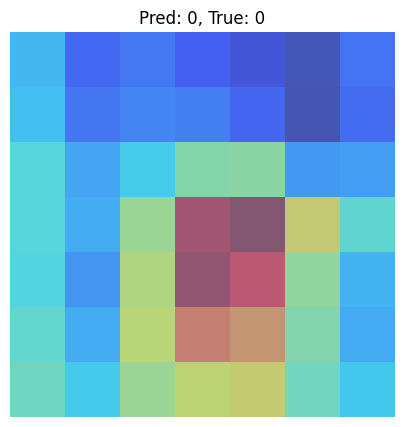

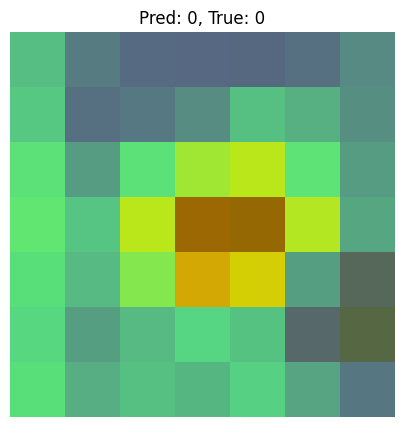

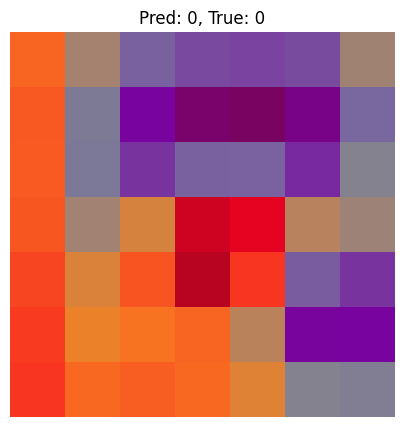

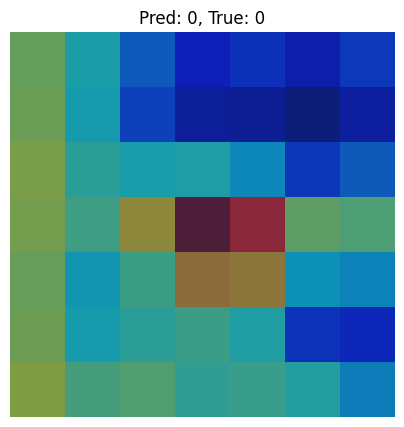

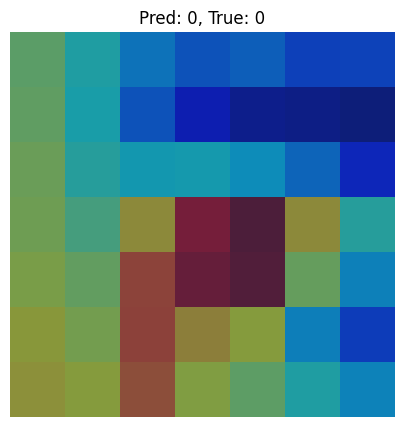

In [ ]:
# Last conv layer in DRResNet
target_layer = model.layer4[1].conv2
visualize_gradcam(model, test_loader, target_layer, device, num_images=5)
